# Predykcja decyzji kredytowej

## Streszczenie:
W pracy użyto dane umożliwiające predykcje udzielenia kredytu. Zawierają one 45000 rekordów i 14 atrybutów. Zmienna loan_status pozwala nam na utworzenie modeli przewidujących jej wartość (0 lub 1) na podstawie pozostałych atrybutów.<br>Decyzje kredytowe odgrywają kluczową rolę w procesach finansowych, zarówno dla instytucji kredytowych, jak i dla samych konsumentów. Właściwe przewidywanie wyników takich decyzji pozwala na zwiększenie efektywności procesów kredytowych, zmniejszenie ryzyka kredytowego oraz poprawę doświadczenia użytkownika. W związku z tym, zastosowanie technik analitycznych w celu automatyzacji i przewidywania decyzji kredytowych staje się coraz bardziej popularne w branży finansowej.
## Słowa kluczowe:
Klasyfikacja, Kredyt, Logistic Regresion, Random Forest, XGBoost, SGDClassifier, model hybrydowy

# Cel i zakres:
Celem niniejszej pracy jest stworzenie modelu antycypacji decyzji kredytowej, który umożliwia przewidywanie wyniku wniosku kredytowego na podstawie różnych zmiennych.<br>W obliczeniach wykorzystane zostały popularne algorytmy uczenia maszynowego: Logistic Regression, Random Forest, XGBoost, XGDClassifier oraz został stworzony model hybrydowy.


# Dane:

| Zmienna                        | Typ             | Opis                                                                                                     |
|--------------------------------|-----------------|----------------------------------------------------------------------------------------------------------|
| person_age                         | Ciągła    | Wiek                                                                                                      |
| person_gender                            | Kategoryczna          | Płeć                                                                                                      |
| person_education                         | Kategoryczna          | Wykształcenie                                                                                                    |
| person_income                         | Ciągła          | Roczny dochód                                                                                                      |
| person_emp_exp | Całkowita         | Liczba lat pracy                                                     |
| person_home_ownership                           | Kategoryczna         | Status posiadania domu (np. wynajem, własność, kredyt hipoteczny)                                                          |
| loan_amnt                           | Ciągła          | Kwota wnioskowanego kredytu                                                             |
| loan_intent                            | Kategoryczna          | Cel kredytu                                                                |
| loan_int_rate                           | Ciągła    | Oprocentowanie kredytu                                                                 |
| loan_percent_income                          | Ciągła         | Kwota kredytu jako procent rocznego dochodu                                                                                    |
| cb_person_cred_hist_length                           | Ciągła          | Długość historii kredytowej w latach                                                                              |
| credit_score                            | Całkowita         | Ocena kredytowa osoby                                                            |
| previous_loan_defaults_on_file                            | Kategoryczna          | Wskaźnik wcześniejszych zaległości w spłacie kredytów                                                                      |
| loan_status (target variable)                            | Całkowita          | Status zatwierdzenia kredytu: 1 = zatwierdzony; 0 = odrzucony    |


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import kds
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from pygam import LogisticGAM, s, f
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report,roc_curve,auc
import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set_style('whitegrid')
df = pd.read_csv("dane.csv",sep = ',')
x = df.iloc[:,:13]
Y = df.iloc[:,13:14]

In [3]:
x.dtypes
x_num = x.select_dtypes(('int64','float64'))
x_cat = x.select_dtypes('object')
x_num['person_income_ln'] = np.log(x_num['person_income'])
x_num['person_income_ln'].describe()
x_num.drop('person_income',axis='columns',inplace = True)

# Statystyki Opisowe:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [5]:
df.describe()

,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,loan_status
count,45000.000000,4.500000e+04,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,27.764178,8.031905e+04,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756,0.222222
std,6.045108,8.042250e+04,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865,0.415744
min,20.000000,8.000000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,390.000000,0.000000
25%,24.000000,4.720400e+04,1.000000,5000.000000,8.590000,0.070000,3.000000,601.000000,0.000000
50%,26.000000,6.704800e+04,4.000000,8000.000000,11.010000,0.120000,4.000000,640.000000,0.000000
75%,30.000000,9.578925e+04,8.000000,12237.250000,12.990000,0.190000,8.000000,670.000000,0.000000
max,144.000000,7.200766e+06,125.000000,35000.000000,20.000000,0.660000,30.000000,850.000000,1.000000


In [6]:
df.describe(include='object')

,person_gender,person_education,person_home_ownership,loan_intent,previous_loan_defaults_on_file
count,45000,45000,45000,45000,45000
unique,2,5,4,6,2
top,male,Bachelor,RENT,EDUCATION,Yes
freq,24841,13399,23443,9153,22858


# Podstawowa wizualizacja :

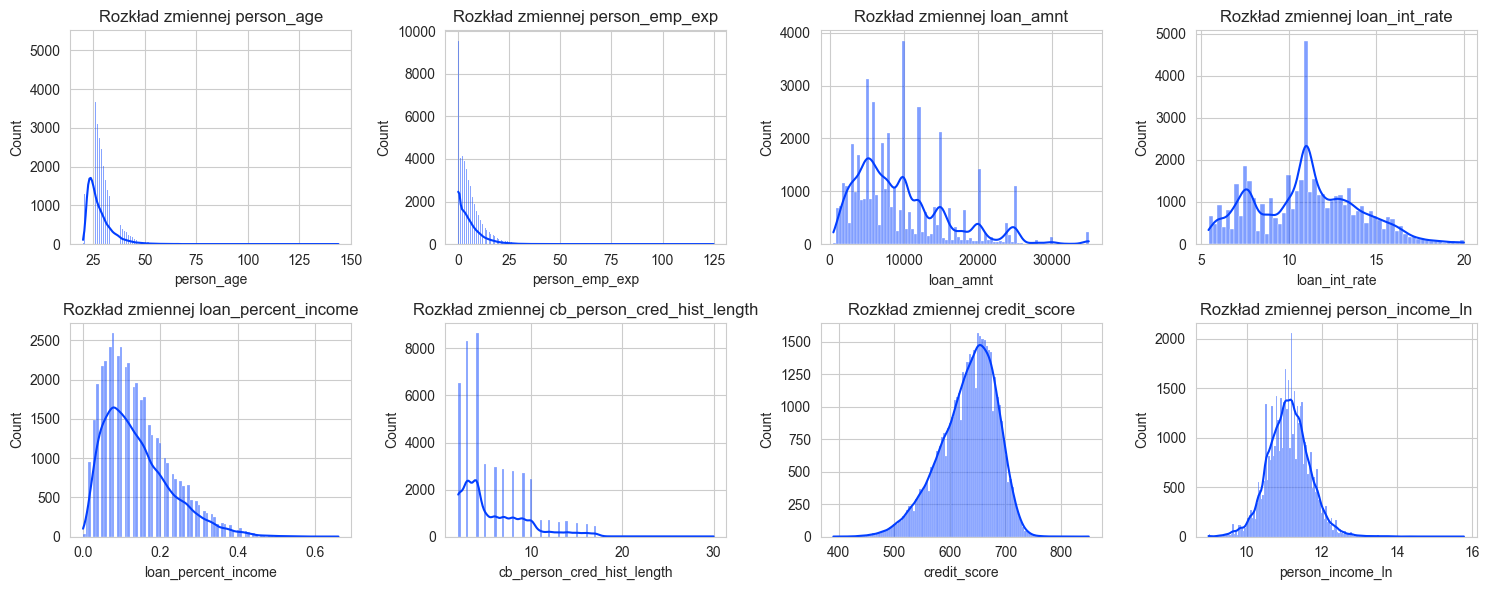

In [7]:
plt.figure(figsize=(15, 6))
sns.set_palette("bright")
for i, column in enumerate(x_num.columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(x_num[column], kde=True)
    plt.title(f'Rozkład zmiennej {column}')
plt.tight_layout()
plt.show()

Wykresy przedstawiające zmienne liczbowe z pliku

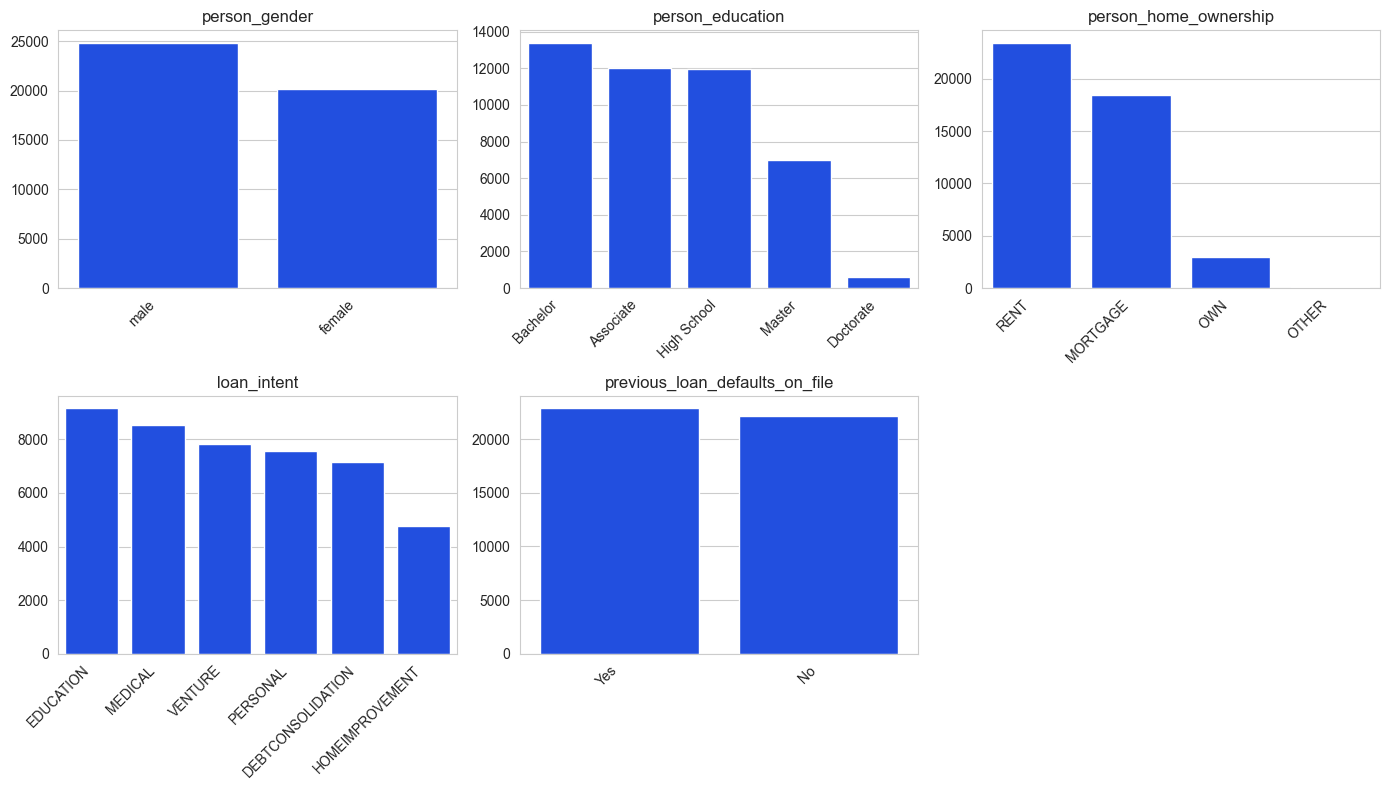

In [8]:
plt.figure(figsize=(14, 8))
sns.set_palette("bright")

for i, column in enumerate(x_cat.columns, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=x_cat[column], order=x_cat[column].value_counts().index)
    plt.title(column)
    plt.xlabel("")
    plt.ylabel("")  
    plt.tight_layout()
    plt.xticks(rotation=45, ha='right')

plt.show()

Wykresy kołowe przedstawiające zmienne dyskretne z pliku

# Obserwacje odstające: 

In [9]:
Q1 = x_num.quantile(0.25)
Q3 = x_num.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = ((x_num < lower_bound) | (x_num > upper_bound))

outliers_count = outliers.sum()
print("Liczba odstających wartości w każdej kolumnie:")
print(outliers_count)

names = x_num.columns
lista = np.zeros(len(names))

out_up = (x_num > upper_bound)
out_low = (x_num < lower_bound)
print("-------------------------------------")
print(out_up.sum())
print("-------------------------------------")
print(out_low.sum())

Liczba odstających wartości w każdej kolumnie:
person_age                    2188
person_emp_exp                1724
loan_amnt                     2348
loan_int_rate                  124
loan_percent_income            744
cb_person_cred_hist_length    1366
credit_score                   467
person_income_ln               798
dtype: int64
-------------------------------------
person_age                    2188
person_emp_exp                1724
loan_amnt                     2348
loan_int_rate                  124
loan_percent_income            744
cb_person_cred_hist_length    1366
credit_score                     7
person_income_ln               434
dtype: int64
-------------------------------------
person_age                      0
person_emp_exp                  0
loan_amnt                       0
loan_int_rate                   0
loan_percent_income             0
cb_person_cred_hist_length      0
credit_score                  460
person_income_ln              364
dtype: int64


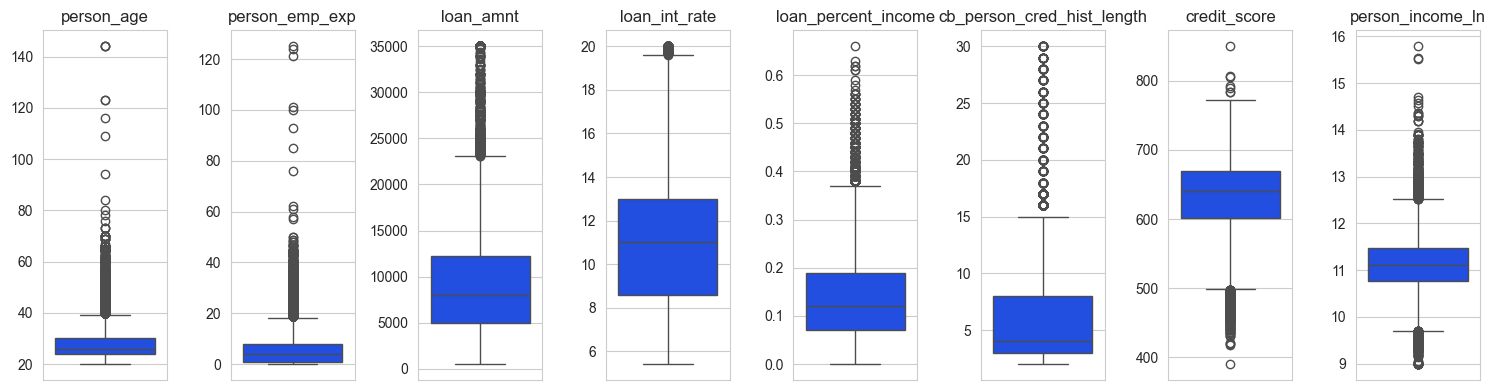

In [10]:
plt.figure(figsize=(15, 4))
for i, column in enumerate(x_num.columns, 1):
    plt.subplot(1, 8, i)
    sns.boxplot(y=x_num[column])
    plt.title(f'{column}')
    plt.ylabel('')
plt.tight_layout()
plt.show()

Wykresy box plot przedstawiające obserwacje odstające w zmiennych liczbowych

In [11]:
for i in names:
    x_num[i] = np.where(x_num[i] < lower_bound[i], lower_bound[i], x_num[i])
    x_num[i] = np.where(x_num[i] > upper_bound[i], upper_bound[i], x_num[i])

outliers2 = ((x_num < lower_bound) | (x_num > upper_bound))
outliers_count2 = outliers2.sum()
print(outliers_count2)

person_age                    0
person_emp_exp                0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_cred_hist_length    0
credit_score                  0
person_income_ln              0
dtype: int64


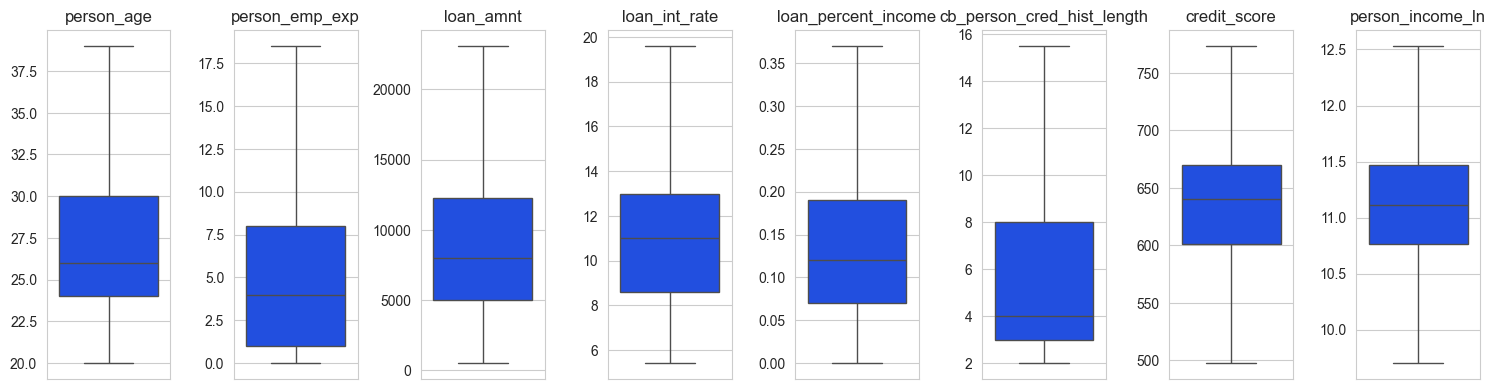

In [12]:
plt.figure(figsize=(15, 4))
for i, column in enumerate(x_num.columns, 1):
    plt.subplot(1, 8, i)
    sns.boxplot(y=x_num[column])
    plt.title(f'{column}')
    plt.ylabel('')
plt.tight_layout()
plt.show()

Wykresy pudełkowe przedstawiające zmienne liczbowe po usunięciu obserwacji odstających

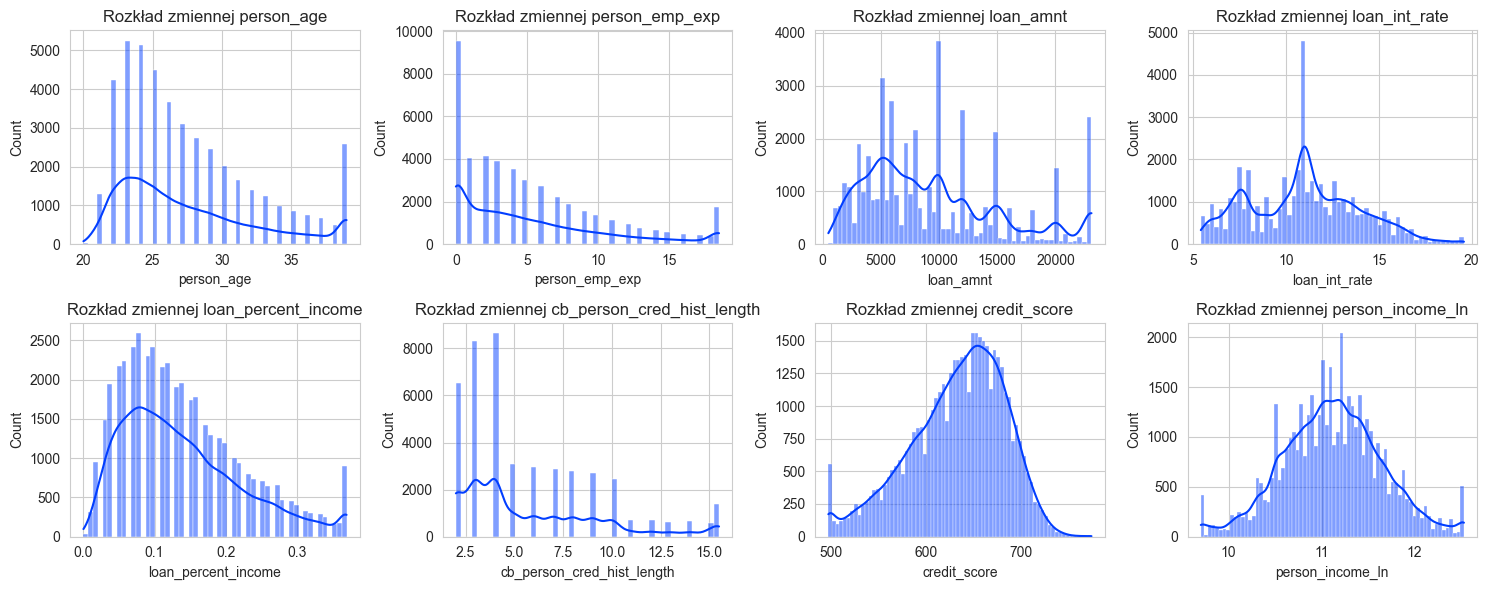

In [13]:
plt.figure(figsize=(15, 6))
sns.set_palette("bright")
for i, column in enumerate(x_num.columns, 1):
    plt.subplot(2, 4, i)
    sns.histplot(x_num[column], kde=True)
    plt.title(f'Rozkład zmiennej {column}')
plt.tight_layout()
plt.show()

Wykresy przedstawiające zmienne liczbowe po usunięciu obserwacji odstających

In [14]:
mappings = {}
mappings['person_gender'] = {'male': 0, 'female': 1}
mappings['person_education'] = {'High School': 0, 'Associate': 1, 'Bachelor': 2, 'Master': 3, 'Doctorate': 4}
mappings['person_home_ownership'] = {'RENT': 0, 'MORTGAGE': 1, 'OWN': 2, 'OTHER': 3}
mappings['loan_intent'] = {'DEBTCONSOLIDATION': 0, 'EDUCATION': 1, 'HOMEIMPROVEMENT': 2, 'MEDICAL': 3, 'PERSONAL': 4, 'VENTURE': 5}
mappings['previous_loan_defaults_on_file'] = {'No': 0, 'Yes': 1}

for column, mapping in mappings.items():
    x_cat[column] = x_cat[column].map(mapping)

Zamienienie wartości zmiennych które są napisami na liczby

<Axes: >

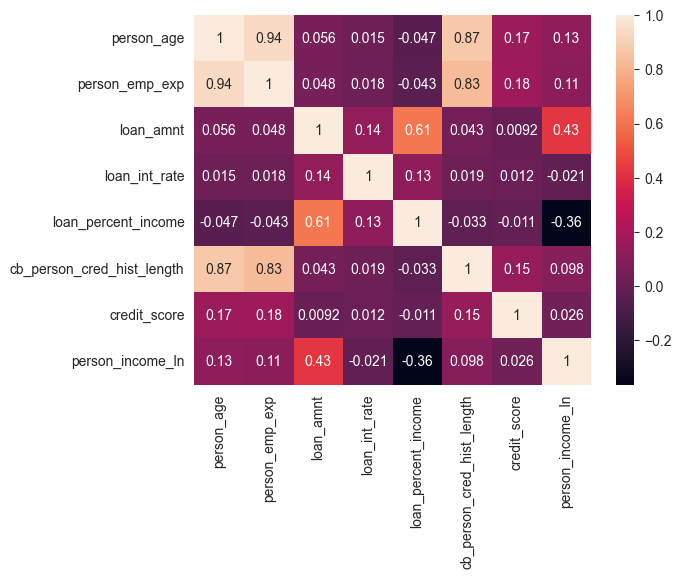

In [15]:
x_num_corr = x_num.corr()
sns.heatmap(x_num_corr, annot=True)

Macierz korelacji

In [16]:
x_num.columns

Index(['person_age', 'person_emp_exp', 'loan_amnt', 'loan_int_rate',
       'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score',
       'person_income_ln'],
      dtype='object')

<Axes: >

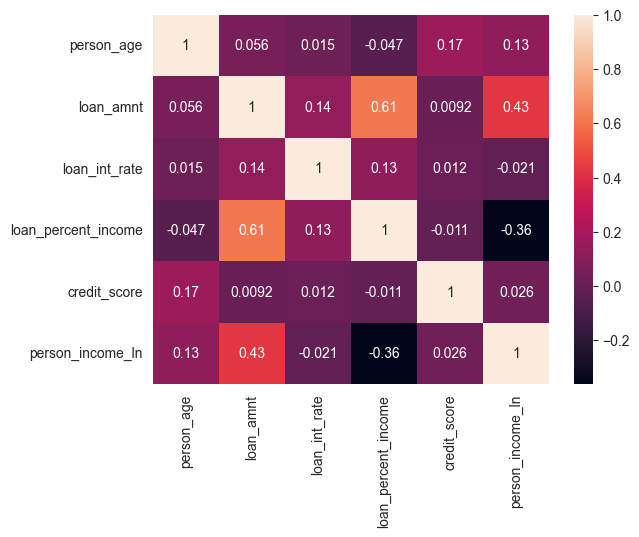

In [17]:
x_num.drop(['person_emp_exp', 'cb_person_cred_hist_length'], axis=1, inplace=True)
x_num_corr = x_num.corr()
sns.heatmap(x_num_corr, annot=True)

Macierz korelacji po usunieciu zmiennych nadmiernie skorelowanych

In [18]:
num_names = x_num.columns
cat_names = x_cat.columns
scaler_standaryzacja = StandardScaler()
scaler_min_max = MinMaxScaler(feature_range=(0,1))
x_num = scaler_standaryzacja.fit_transform(x_num)
x_cat = scaler_min_max.fit_transform(x_cat)
x_num = pd.DataFrame(x_num, columns=num_names)
x_cat = pd.DataFrame(x_cat, columns=cat_names)
x = pd.concat([x_num,x_cat], axis=1)
x.shape

(45000, 11)

# RANDOM FOREST
## Opis metody:
Random Forest to algorytm oparty na metodzie ensemble, który tworzy wiele drzew decyzyjnych, a następnie łączy ich wyniki w celu uzyskania bardziej stabilnej i dokładnej prognozy. Las losowy jest bardzo skuteczny w radzeniu sobie z dużą liczbą cech oraz w eliminowaniu problemu przeuczenia (overfitting). Dzięki swojej wszechstronności jest stosowany w różnych zadaniach klasyfikacyjnych, w tym w przewidywaniu decyzji kredytowych.

In [19]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.3, random_state=seed)

In [20]:
print("Treningowy:")
print(y_train.value_counts())
print("\nTestowy:")
print(y_test.value_counts())

Treningowy:
loan_status
0              24507
1               6993
Name: count, dtype: int64

Testowy:
loan_status
0              10493
1               3007
Name: count, dtype: int64


In [21]:
rf = RandomForestClassifier(random_state=seed, n_jobs=-1)
rf.fit(x_train, y_train)

# predykcje
y_pred_train = rf.predict(x_train)
y_pred_test = rf.predict(x_test)

# metryki
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f'TRAIN ACCURACY: {train_accuracy}')
print(f'TEST ACCURACY: {test_accuracy}\n')
print(classification_report(y_test, y_pred_test))

TRAIN ACCURACY: 1.0
TEST ACCURACY: 0.9248148148148149

              precision    recall  f1-score   support

           0       0.94      0.97      0.95     10493
           1       0.88      0.77      0.82      3007

    accuracy                           0.92     13500
   macro avg       0.91      0.87      0.89     13500
weighted avg       0.92      0.92      0.92     13500



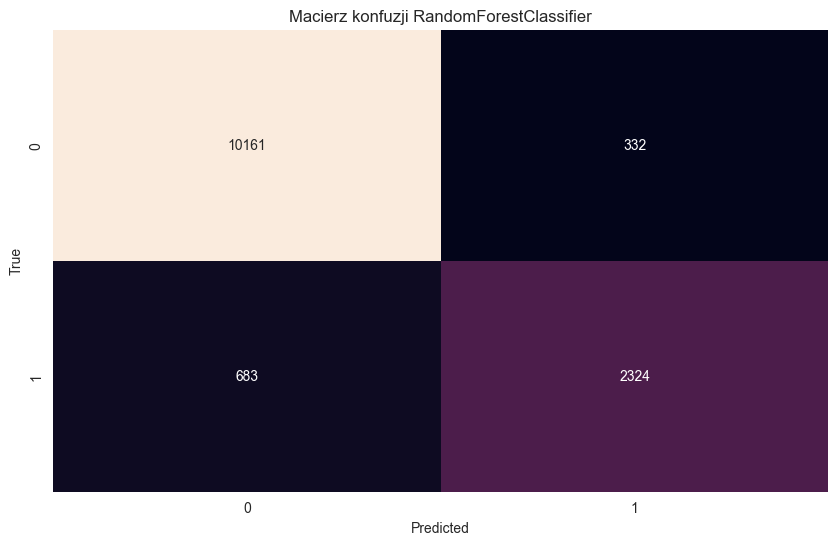

In [22]:
# macierz konfuzji
macierz_konfuzji = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 6))
sns.heatmap(macierz_konfuzji, annot=True, fmt='d', cbar=False)
plt.title(f"Macierz konfuzji {type(rf).__name__}")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

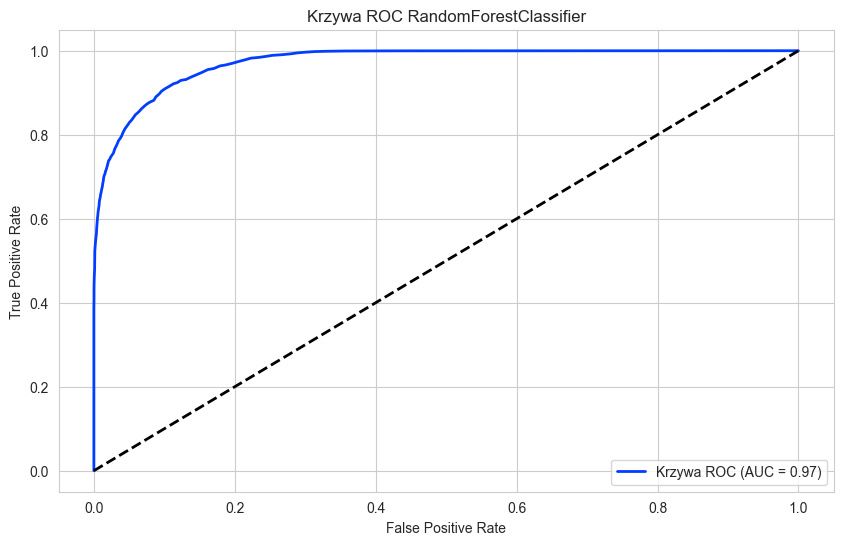

In [23]:
# krzywa ROC
y_prob_test = rf.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Krzywa ROC {type(rf).__name__}")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

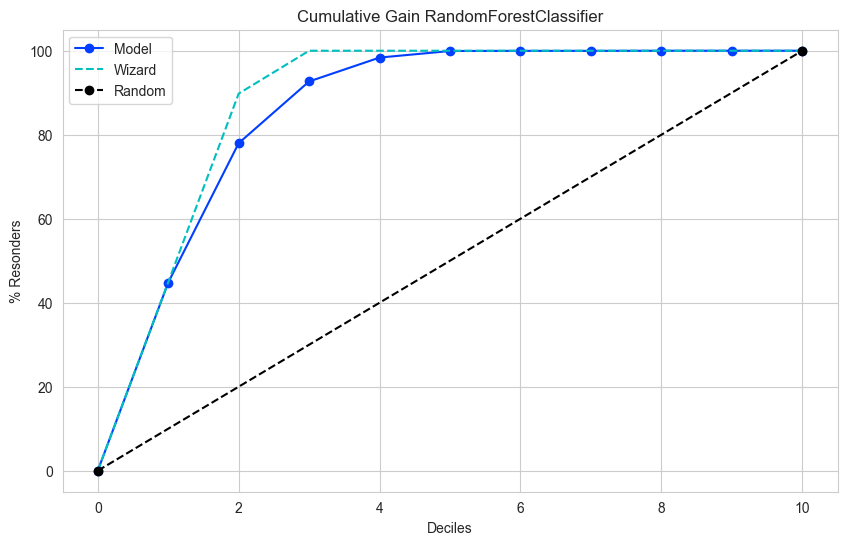

In [24]:
# cumulative gain
plt.figure(figsize=(10, 6))
kds.metrics.plot_cumulative_gain(y_test['loan_status'], y_prob_test)
plt.title(f"Cumulative Gain {type(rf).__name__}")
plt.show()

# Model - stoworzony model
# Wizard - teoretyczny najlepszy model (benchmark)
# Random - losowy wybór

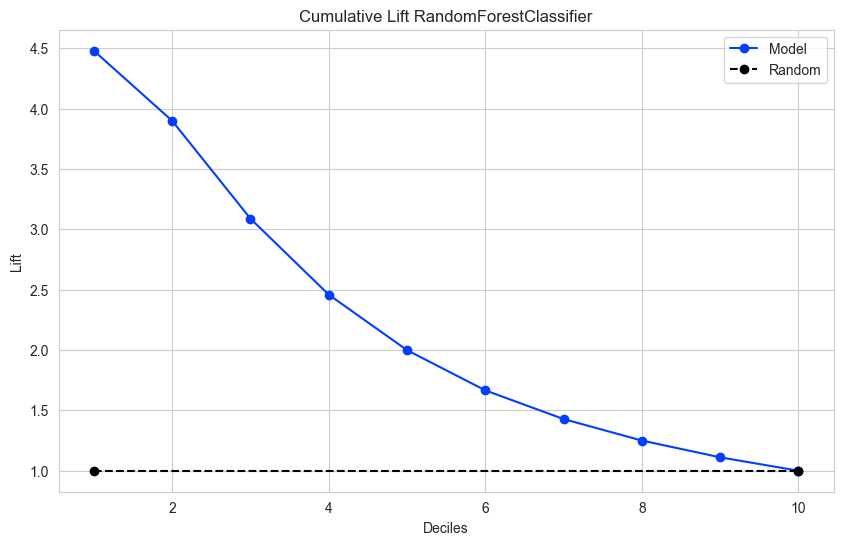

In [25]:
plt.figure(figsize=(10, 6))
kds.metrics.plot_lift(y_test['loan_status'], y_prob_test)
plt.title(f"Cumulative Lift {type(rf).__name__}")
plt.show()

# Oś Y: Lift - mówi, ile razy lepiej model znajduje osoby z pozytywną odpowiedzią w danym decylu, w porównaniu do losowego wyboru.
# Oś X: Deciles - kolejne 10% najlepiej rokujących klientów według modelu

# SGDclassifier
## Opis metody:
SGDClassifier to implementacja klasyfikatora opartego na stochastycznym spadku gradientu (SGD). Jest to algorytm optymalizacji, który stosuje spadek gradientu do iteracyjnego dopasowywania modeli. Może być używany z różnymi funkcjami straty (np. dla regresji logistycznej, SVM itp.), a jego główną cechą jest to, że przy każdej iteracji aktualizuje parametry na podstawie jednej próbki lub małej partii próbek (mini-batch), co sprawia, że jest szybki, zwłaszcza w przypadku dużych zbiorów danych.

In [26]:
seed = 42
x_train_sgd, x_test_sgd, y_train_sgd, y_test_sgd = train_test_split(x, Y, test_size=0.3, random_state=seed)

In [27]:
print("Treningowy:")
print(y_train_sgd.value_counts())
print("\nTestowy:")
print(y_test_sgd.value_counts())

Treningowy:
loan_status
0              24507
1               6993
Name: count, dtype: int64

Testowy:
loan_status
0              10493
1               3007
Name: count, dtype: int64


In [28]:
model = SGDClassifier(loss="hinge", penalty="l2", random_state=seed)
model.fit(x_train_sgd, y_train_sgd)

#predykcja
y_pred_test_sgd=model.predict(x_test_sgd)
y_pred_train_sgd=model.predict(x_train_sgd)

# metryki
train_accuracy = accuracy_score(y_train_sgd, y_pred_train_sgd)
test_accuracy = accuracy_score(y_test_sgd,y_pred_test_sgd)

print(f'TRAIN ACCURACY: {train_accuracy}')
print(f'TEST ACCURACY: {test_accuracy}\n')
print(classification_report(y_test_sgd, y_pred_test_sgd))

TRAIN ACCURACY: 0.8934920634920634
TEST ACCURACY: 0.888962962962963

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10493
           1       0.75      0.75      0.75      3007

    accuracy                           0.89     13500
   macro avg       0.84      0.84      0.84     13500
weighted avg       0.89      0.89      0.89     13500



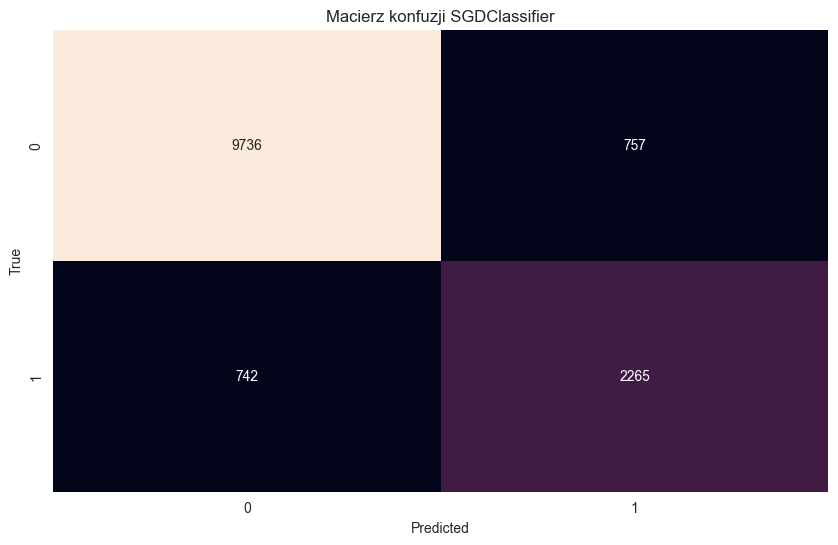

In [29]:
# macierz konfuzji
macierz_konfuzji = confusion_matrix(y_test_sgd, y_pred_test_sgd)
plt.figure(figsize=(10, 6))
sns.heatmap(macierz_konfuzji, annot=True, fmt='d', cbar=False)
plt.title(f"Macierz konfuzji {type(model).__name__}")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

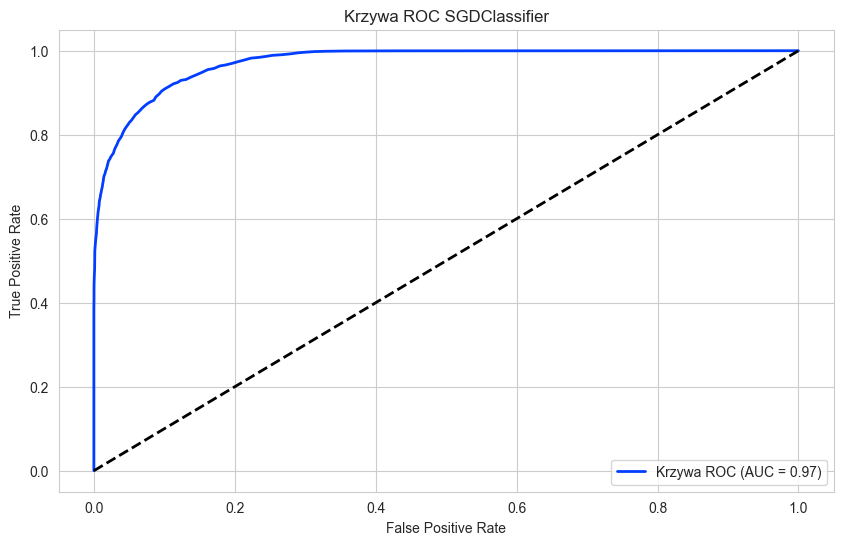

In [30]:
y_prob_test_sgd = model.decision_function(x_test_sgd)
fpr, tpr, thresholds = roc_curve(y_test_sgd, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Krzywa ROC {type(model).__name__}")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

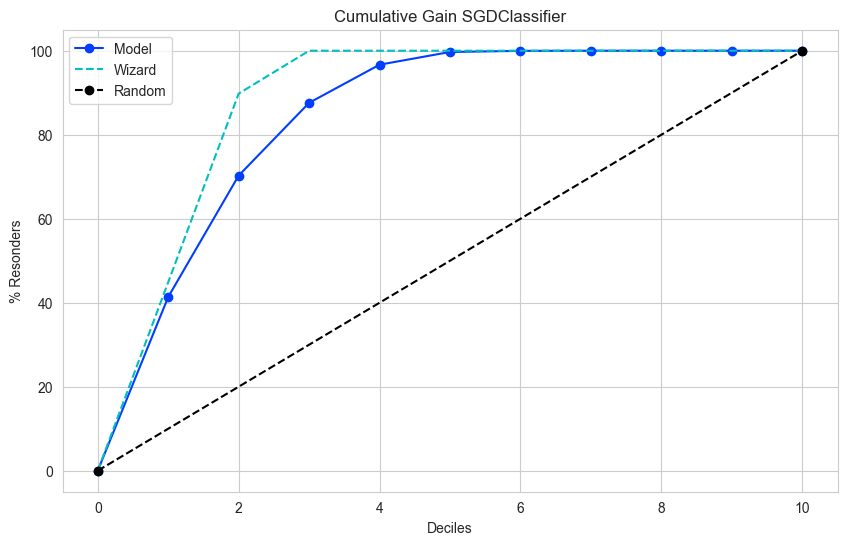

In [31]:
plt.figure(figsize=(10, 6))
kds.metrics.plot_cumulative_gain(y_test_sgd['loan_status'], y_prob_test_sgd)
plt.title(f"Cumulative Gain {type(model).__name__}")
plt.show()

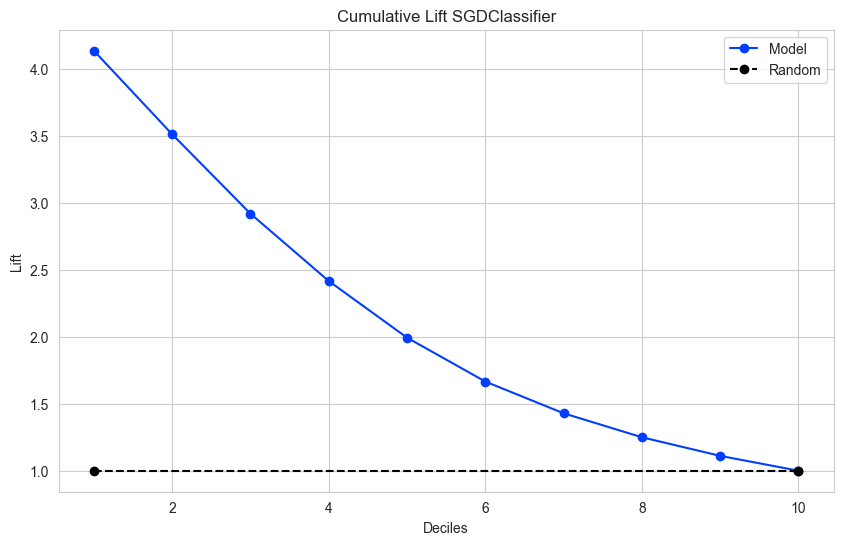

In [32]:
plt.figure(figsize=(10, 6))
kds.metrics.plot_lift(y_test_sgd['loan_status'], y_prob_test_sgd)
plt.title(f"Cumulative Lift {type(model).__name__}")
plt.show()

# XGBoost
## Opis metody:
XGBoost to zaawansowany algorytm oparty na gradientowym wzmacnianiu, który jest jednym z najpopularniejszych narzędzi w analizie danych. XGBoost jest szczególnie efektywny w rozwiązywaniu problemów klasyfikacyjnych, oferując lepszą wydajność w porównaniu z tradycyjnymi modelami, dzięki technikom takim jak regularyzacja, optymalizacja gradientowa i obsługa brakujących danych. Algorytm ten często osiąga wysoką skuteczność w zadaniach predykcyjnych.

In [33]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.3, random_state=seed)

In [34]:
print("Treningowy:")
print(y_train.value_counts())
print("\nTestowy:")
print(y_test.value_counts())

Treningowy:
loan_status
0              24507
1               6993
Name: count, dtype: int64

Testowy:
loan_status
0              10493
1               3007
Name: count, dtype: int64


In [35]:
model_xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss')
model_xgb.fit(x_train, y_train)

# predykcje
y_pred_train = model_xgb.predict(x_train)
y_pred_test = model_xgb.predict(x_test)

# metryki
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f'TRAIN ACCURACY: {train_accuracy}')
print(f'TEST ACCURACY: {test_accuracy}\n')
print(classification_report(y_test, y_pred_test))

TRAIN ACCURACY: 0.9712380952380952
TEST ACCURACY: 0.9303703703703704

              precision    recall  f1-score   support

           0       0.94      0.97      0.96     10493
           1       0.88      0.80      0.84      3007

    accuracy                           0.93     13500
   macro avg       0.91      0.88      0.90     13500
weighted avg       0.93      0.93      0.93     13500



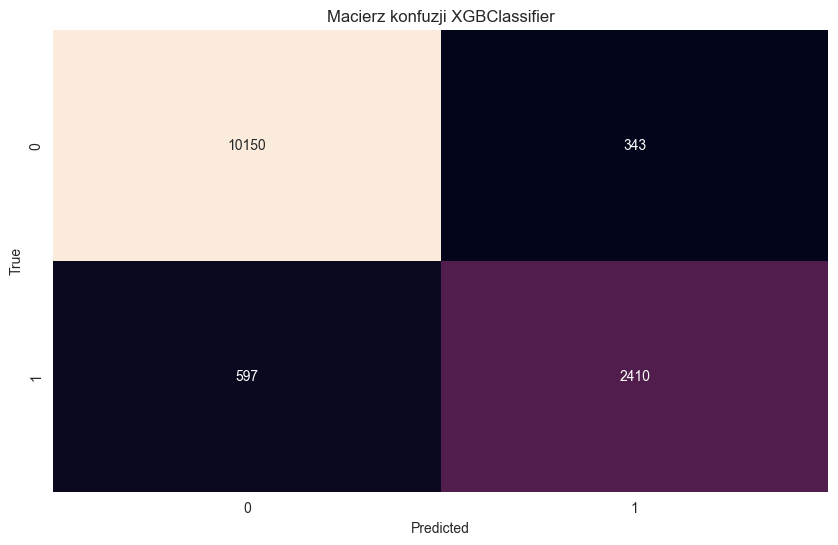

In [36]:
macierz_konfuzji = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 6))
sns.heatmap(macierz_konfuzji, annot=True, fmt='d', cbar=False)
plt.title(f"Macierz konfuzji {type(model_xgb).__name__}")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

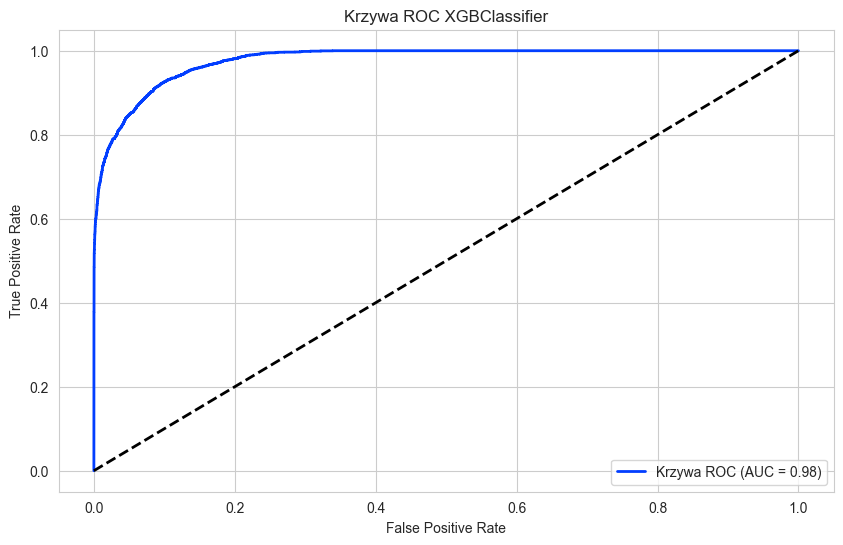

In [37]:
y_prob_test = model_xgb.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Krzywa ROC {type(model_xgb).__name__}")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

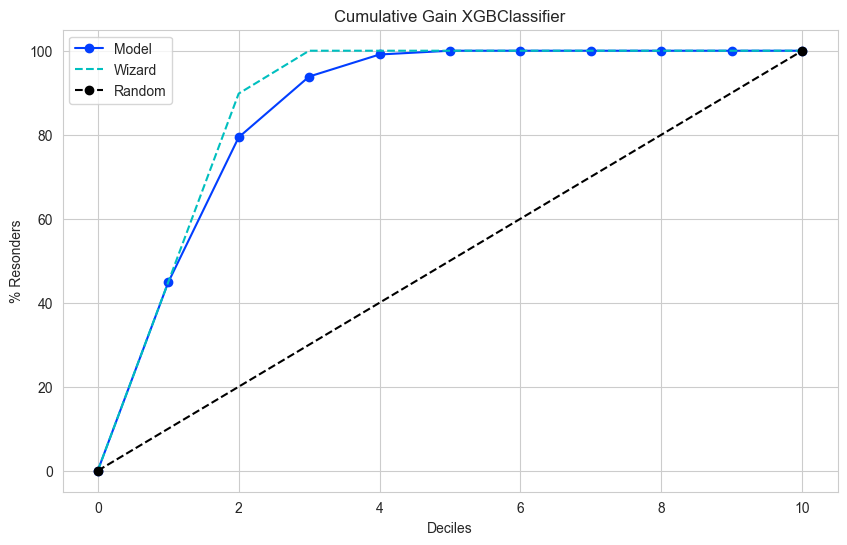

In [38]:
plt.figure(figsize=(10, 6))
kds.metrics.plot_cumulative_gain(y_test['loan_status'], y_prob_test)
plt.title(f"Cumulative Gain {type(model_xgb).__name__}")
plt.show()

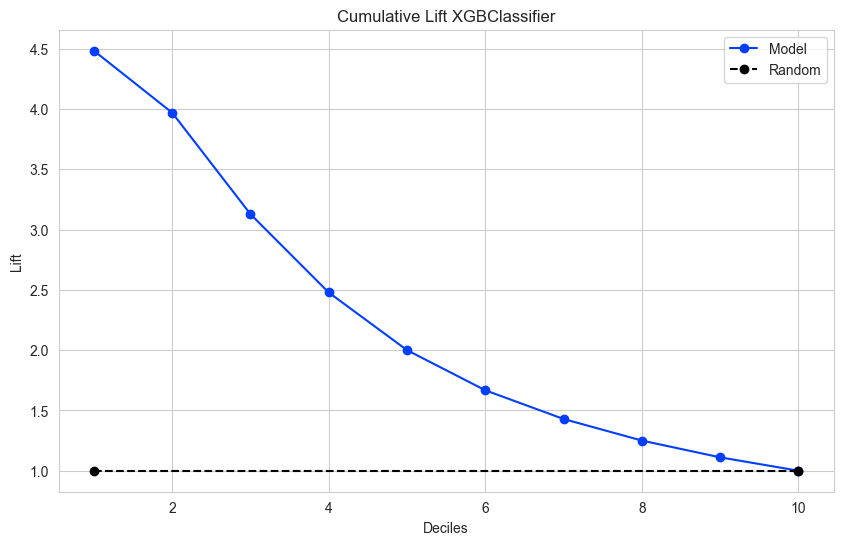

In [39]:
plt.figure(figsize=(10, 6))
kds.metrics.plot_lift(y_test['loan_status'], y_prob_test)
plt.title(f"Cumulative Lift {type(model_xgb).__name__}")
plt.show()

# Logistic Regression
## Opis metody:
Jest to klasyczny model statystyczny używany do przewidywania wyników zmiennych binarnych. Regresja logistyczna jest stosunkowo prostym algorytmem, który analizuje zależności między zmiennymi wejściowymi a prawdopodobieństwem jednej z dwóch możliwych klas wyjściowych (np. zatwierdzony/odrzucony kredyt). Model ten jest szczególnie przydatny w przypadku problemów, gdzie zależności między cechami a wynikiem są liniowe.

In [40]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.3, random_state=seed)

In [41]:
print("Treningowy:")
print(y_train.value_counts())
print("\nTestowy:")
print(y_test.value_counts())

Treningowy:
loan_status
0              24507
1               6993
Name: count, dtype: int64

Testowy:
loan_status
0              10493
1               3007
Name: count, dtype: int64


In [42]:
log_reg = LogisticRegression(max_iter=1000, random_state=seed)
log_reg.fit(x_train, y_train)

# predykcje
y_pred_train = log_reg.predict(x_train)
y_pred_test = log_reg.predict(x_test)

# metryki
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f'TRAIN ACCURACY: {train_accuracy}')
print(f'TEST ACCURACY: {test_accuracy}\n')
print(classification_report(y_test, y_pred_test))

TRAIN ACCURACY: 0.8957460317460317
TEST ACCURACY: 0.8925925925925926

              precision    recall  f1-score   support

           0       0.93      0.93      0.93     10493
           1       0.76      0.75      0.76      3007

    accuracy                           0.89     13500
   macro avg       0.85      0.84      0.84     13500
weighted avg       0.89      0.89      0.89     13500



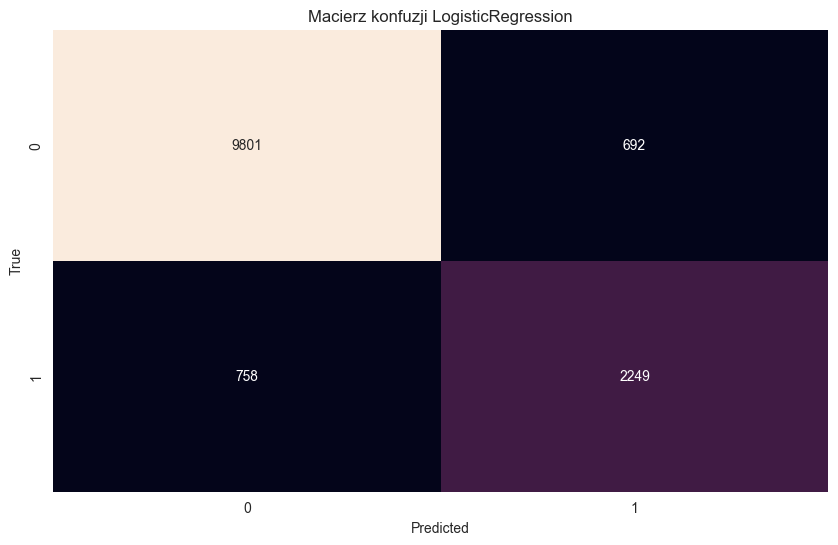

In [43]:
macierz_konfuzji = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 6))
sns.heatmap(macierz_konfuzji, annot=True, fmt='d', cbar=False)
plt.title(f"Macierz konfuzji {type(log_reg).__name__}")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

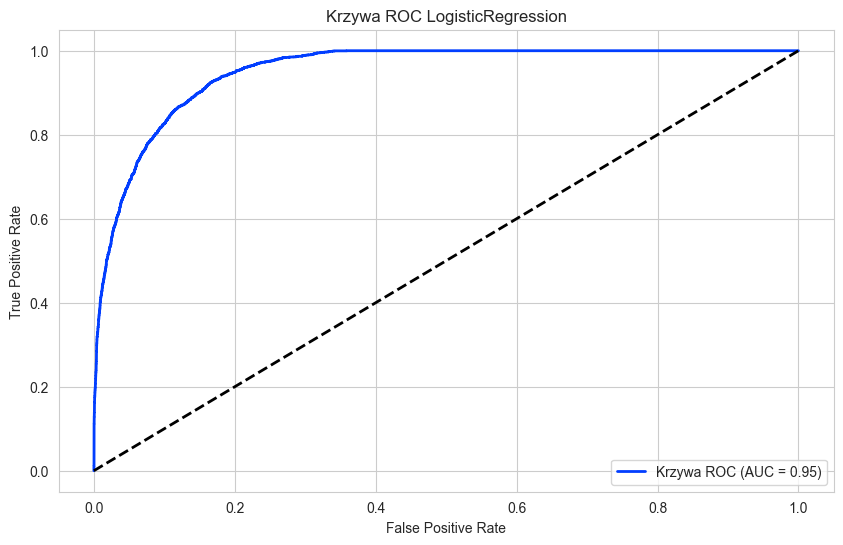

In [44]:
y_prob_test = log_reg.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Krzywa ROC {type(log_reg).__name__}")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

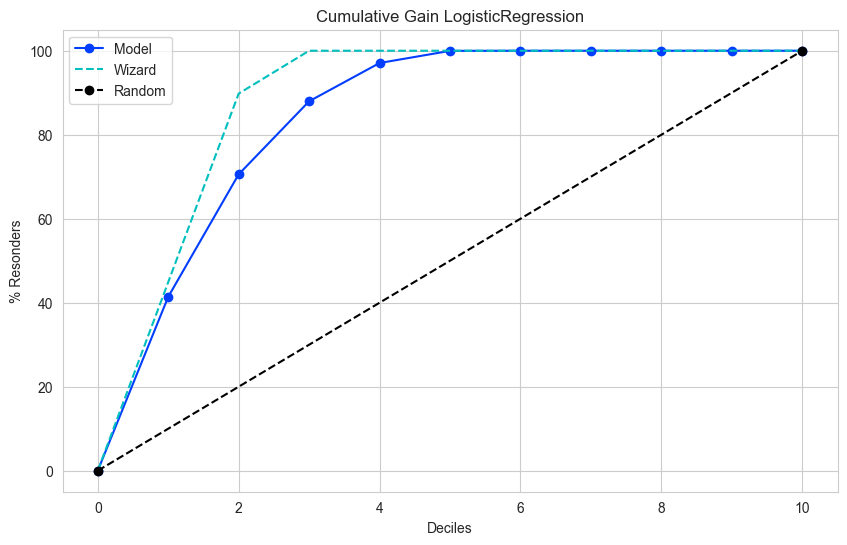

In [45]:
plt.figure(figsize=(10, 6))
kds.metrics.plot_cumulative_gain(y_test['loan_status'], y_prob_test)
plt.title(f"Cumulative Gain {type(log_reg).__name__}")
plt.show()

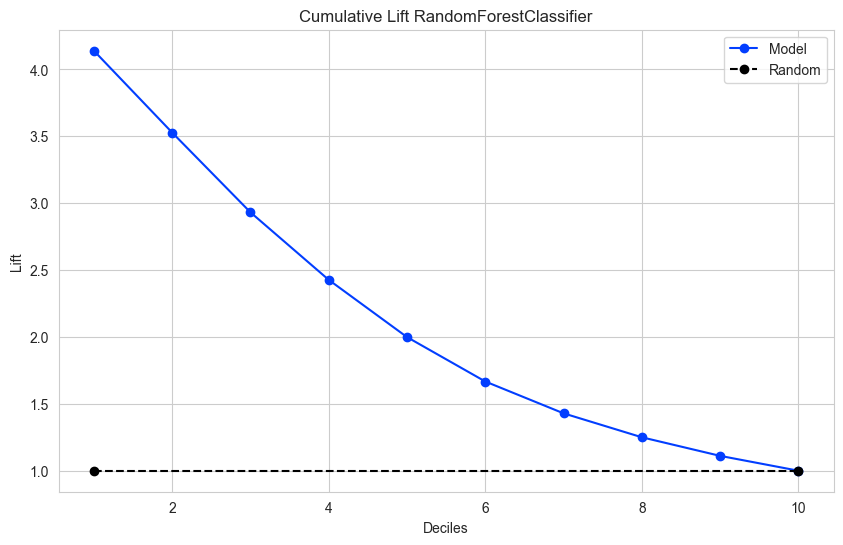

In [46]:
plt.figure(figsize=(10, 6))
kds.metrics.plot_lift(y_test['loan_status'], y_prob_test)
plt.title(f"Cumulative Lift {type(rf).__name__}")
plt.show()

# Model hybrydowy

In [47]:
seed=42
x_train, x_test, y_train, y_test = train_test_split(x, Y, test_size=0.3, random_state=seed)

In [48]:
hybrydowy = [
    ('random_forest', rf),
    ('xgboost', model_xgb),
    ('logistic_regression', log_reg)
]

stacking = StackingClassifier(
    estimators=hybrydowy,
    final_estimator=LogisticRegression(max_iter=1000, random_state=seed),
    cv=5,
)

In [49]:
stacking.fit(x_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(n_jobs=-1,
                                                       random_state=42)),
                               ('xgboost',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None, gamma...
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('logistic_regression',
                                LogisticRegression(max_iter=1000,
                                                   random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
                                                      random_state=42))

In [50]:
# predykcje
y_pred_train = stacking.predict(x_train)
y_pred_test = stacking.predict(x_test)

# metryki
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f'TRAIN ACCURACY: {train_accuracy}')
print(f'TEST ACCURACY: {test_accuracy}\n')
print(classification_report(y_test, y_pred_test))

TRAIN ACCURACY: 0.9876190476190476
TEST ACCURACY: 0.9318518518518518

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     10493
           1       0.88      0.80      0.84      3007

    accuracy                           0.93     13500
   macro avg       0.91      0.89      0.90     13500
weighted avg       0.93      0.93      0.93     13500



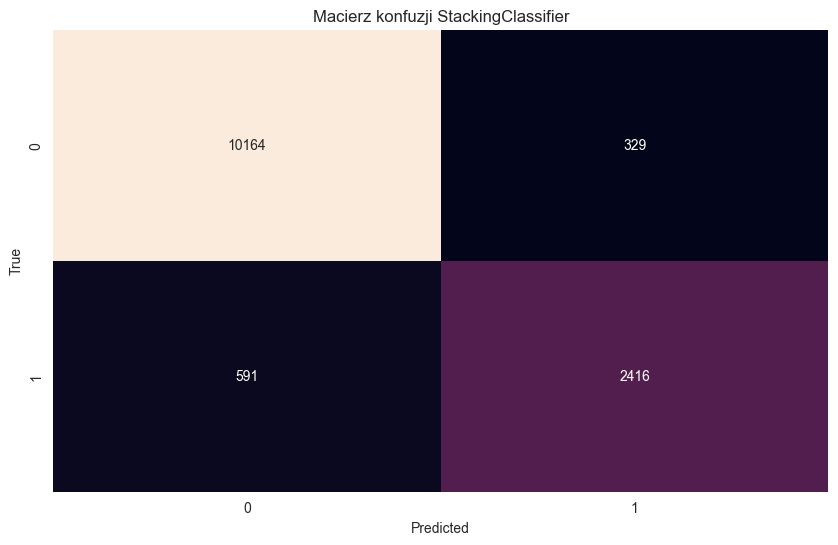

In [51]:
macierz_konfuzji = confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(10, 6))
sns.heatmap(macierz_konfuzji, annot=True, fmt='d', cbar=False)
plt.title(f"Macierz konfuzji {type(stacking).__name__}")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

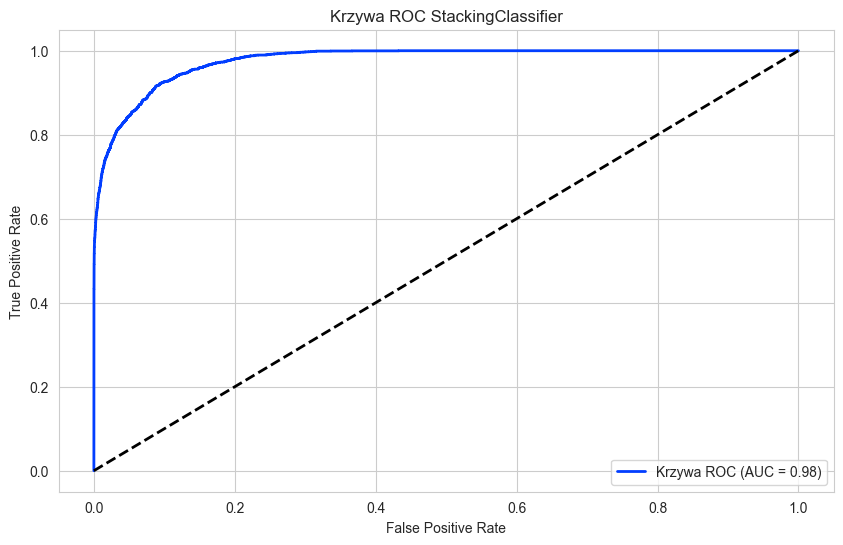

In [52]:
y_prob_test = stacking.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, lw=2, label=f'Krzywa ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"Krzywa ROC {type(stacking).__name__}")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

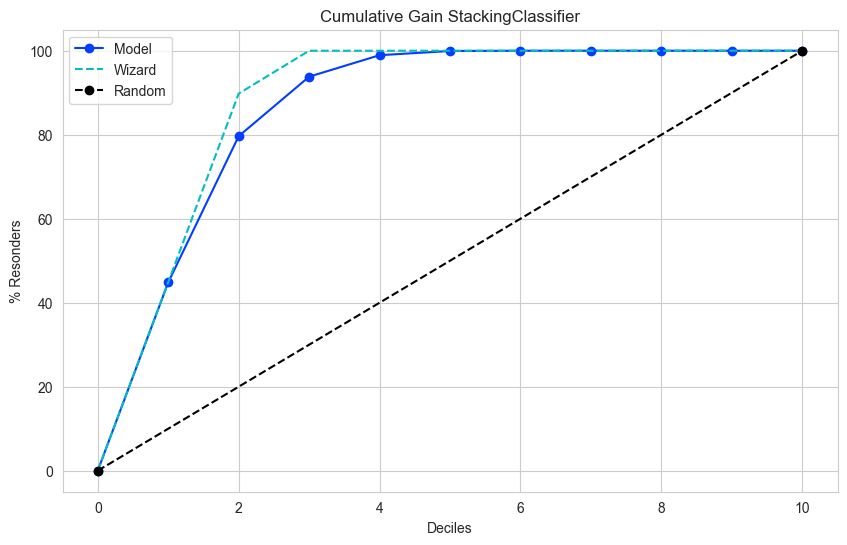

In [53]:
# cumulative gain
plt.figure(figsize=(10, 6))
kds.metrics.plot_cumulative_gain(y_test['loan_status'], y_prob_test)
plt.title(f"Cumulative Gain {type(stacking).__name__}")
plt.show()

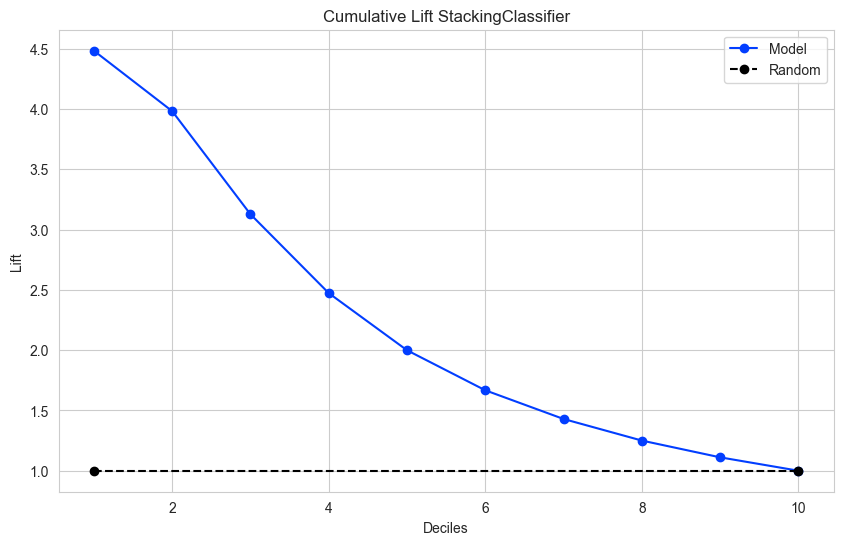

In [54]:
plt.figure(figsize=(10, 6))
kds.metrics.plot_lift(y_test['loan_status'], y_prob_test)
plt.title(f"Cumulative Lift {type(stacking).__name__}")
plt.show()

# Podsumowanie:
Przeprowadzone analizy wykazały, że każdy z zastosowanych modeli charakteryzował się różnym poziomem skuteczności, a ich wydajność zależała od charakterystyki danych. Podsumowując, badanie wykazało, że nowoczesne techniki uczenia maszynowego mogą znacząco wspierać procesy decyzyjne w obszarze finansów. Najlepsze wyniki osiągnął model hybrydowy, aczkolwiek były one jedynie nieznacznie lepsze od wyników uzyskanych przez model XGBoost.

Mimo obiecujących rezultatów, konieczne są dalsze badania, obejmujące m.in. szerszy zakres danych, testowanie innych konfiguracji hiperparametrów, oraz zastosowanie alternatywnych metod ensemble learning. Dodatkowo warto rozważyć analizę wpływu jakości danych wejściowych oraz ich przetwarzania na końcowe wyniki modeli, co może przyczynić się do jeszcze lepszej skuteczności prognoz.

# Bibliografia:
1. Kaggle https://www.kaggle.com/datasets/taweilo/loan-approval-classification-data/data
2. Scikit-learn documentation
3. wikipedia: https://en.wikipedia.org/wiki/Generalized_additive_model
4. GAM: https://www.geeksforgeeks.org/generalized-additive-model-in-python/
5. wikipedia https://en.wikipedia.org/wiki/Random_forest
6. RF https://www.datacamp.com/tutorial/random-forests-classifier-python
7. wikipedia: https://en.wikipedia.org/wiki/Logistic_regression
8. LR https://www.w3schools.com/python/python_ml_logistic_regression.asp
9. wikipedia https://en.wikipedia.org/wiki/XGBoost
10. XGB https://www.datacamp.com/tutorial/xgboost-in-python
11. SGDC https://www.geeksforgeeks.org/stochastic-gradient-descent-classifier/
12. SGDC https://scikit-learn.org/1.5/modules/generated/sklearn.linear_model.SGDClassifier.html
13. NumPy https://numpy.org/doc/stable/